In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import numpy as np
from statsmodels.tsa.seasonal import STL

/Users/marcos/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
import keras

/Users/marcos/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df_price = pd.read_csv('agrodata.csv')
df_weather = pd.read_csv('agroweather_data.csv')

In [4]:
df_price['Price'] = df_price['Price'].astype(float)
Price = df_price['Price']
Price

0       74.0
1       81.0
2       77.0
3       73.0
4       67.0
       ...  
983    125.0
984    125.0
985    124.0
986    122.0
987    115.0
Name: Price, Length: 988, dtype: float64

In [5]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [31]:
train = Price[:365]
val = Price[365:730]
test = Price[730:]

In [32]:
WINDOW_SIZE = 5
X, y = df_to_X_y(train, WINDOW_SIZE)
X.shape, y.shape

((360, 5, 1), (360,))

In [33]:
X_test, y_test = df_to_X_y(test, WINDOW_SIZE)
X_test.shape, y_test.shape

((253, 5, 1), (253,))

In [34]:
X_val, y_val = df_to_X_y(val, WINDOW_SIZE)
X_val.shape, y_val.shape

((360, 5, 1), (360,))

In [35]:
X_test[0] # Estamos usando 5 días para producir una predicción de 1 día, es decir, usamos los 5 días anteriores incluyendo hoy, para realizar la predicción de mañana.9

array([[242.],
       [170.],
       [149.],
       [146.],
       [137.]])

In [36]:
y_test[0]

162.0

In [37]:
X_val, y_val = df_to_X_y(val, WINDOW_SIZE)
X_val.shape, y_val.shape

((360, 5, 1), (360,))

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras import regularizers

In [40]:
model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM((64), kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,667 (69.01 KB)

 Trainable params: 17,667 (69.01 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
cp = ModelCheckpoint('model1.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate = 0.001), metrics=[RootMeanSquaredError()])

In [42]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 25, verbose = 1, restore_best_weights=True)

In [43]:
model.fit(X, y, validation_data=(X_val, y_val), epochs = 250, callbacks =[early_stopping, cp])

Epoch 1/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 13946.6982 - root_mean_squared_error: 118.0767 - val_loss: 25655.4668 - val_root_mean_squared_error: 143.1426
Epoch 2/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12404.5420 - root_mean_squared_error: 111.2367 - val_loss: 25530.6504 - val_root_mean_squared_error: 142.7467
Epoch 3/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12070.6807 - root_mean_squared_error: 109.7360 - val_loss: 25405.5410 - val_root_mean_squared_error: 142.3409
Epoch 4/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14533.5586 - root_mean_squared_error: 120.2832 - val_loss: 25236.2715 - val_root_mean_squared_error: 141.7850
Epoch 5/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13652.4824 - root_mean_squared_error: 116.8695 - val_loss: 24861.8496 - val_root_mean_squared_error: 140.5204
Epoch 6/250
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14273.7227 - root_mean_squared_error: 118.8463 - val_loss: 24025.7988 - val_root_mean_squared_e

In [71]:
def predict_n_steps(model, X_input, n_steps):
    # X_input es la última secuencia observada (por ejemplo, los precios de los últimos 5 días)
    predictions = []
    current_sequence = X_input.copy()
    
    for _ in range(n_steps):
        # Hacer la predicción para el próximo punto
        next_prediction = model.predict(current_sequence[np.newaxis, :])
        predictions.append(next_prediction[0, 0])
        
        # Actualizar la secuencia de entrada con la última predicción
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_prediction
        
    return predictions


last_sequence = X_test[-1]
future_steps = 15  # Pasos a predecir

predictions = predict_n_steps(model, last_sequence, future_steps)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[122.26021, 123.066216, 124.24959, 125.50873, 126.79618, 128.06267, 129.29443, 130.4811, 131.61838, 132.70377, 133.73625, 134.71571, 135.64272, 136.51831, 137.34393]


In [45]:
X_test.shape

(253, 5, 1)

In [46]:
comparativa = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y_test[:15]})
comparativa

,Predictions,Actuals
0,122.260208,162.0
1,123.066216,189.0
2,124.249588,216.0
3,125.508728,214.0
4,126.796181,219.0
5,128.062668,219.0
6,129.294434,213.0
7,130.481094,213.0
8,131.618378,187.0
9,132.703766,167.0


In [47]:
train_predictions = model.predict(X_test).flatten()
train_results = pd.DataFrame(data = {'Predictions':train_predictions, 'Actuals':y_test})
train_results

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step


,Predictions,Actuals
0,134.717484,162.0
1,168.699722,189.0
2,199.324402,216.0
3,224.963181,214.0
4,216.484314,219.0
...,...,...
248,128.657745,125.0
249,123.787277,125.0
250,125.454140,124.0
251,124.676605,122.0


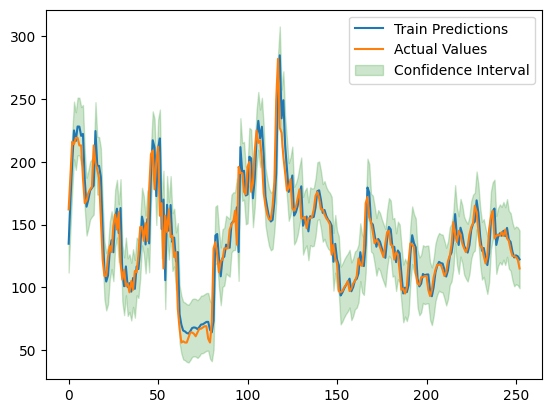

<Figure size 640x480 with 0 Axes>

In [70]:
plt.plot(train_results['Predictions'])
plt.plot(train_results['Actuals'])
# Suponiendo que tienes las predicciones y los intervalos de confianza en train_results
upper_bound = train_results['Predictions'] + 23
lower_bound = train_results['Predictions'] - 23

plt.fill_between(train_results.index, lower_bound, upper_bound, color='green', alpha=0.2)
plt.legend(['Train Predictions', 'Actual Values', 'Confidence Interval'])
plt.show()
plt.clf()

In [64]:
mae = tf.keras.losses.MeanAbsoluteError()

In [65]:
from sklearn.metrics import mean_absolute_error

In [68]:
result = mean_absolute_error(train_results['Actuals'], train_results['Predictions'])
print(f"El error obtenido con LSTM es de {round((result / 100), 2)}€")

El error obtenido con LSTM es de 0.11€


Tenemos un error medio absoluto de 11 céntimos cuando queremos predecir el día siguiente con una ventana de tiempo (número de días de referencia) de 5 días.

In [69]:
value = abs(train_results['Actuals'] - train_results['Predictions'])
value.describe() # Aquí podemos ver la distribución de nuestra pérdida a la hora de hacer la predicción.

count    253.000000
mean      10.881415
std       12.046683
min        0.217911
25%        2.965263
50%        7.246765
75%       14.500793
max       67.876434
dtype: float64

In [30]:
value2 = abs(comparativa['Actuals'] - comparativa['Predictions'])
value2.describe() 

count    15.000000
mean     41.367032
std      35.269806
min       1.265533
25%      17.717209
50%      23.596466
75%      75.505089
max      97.145691
dtype: float64

Tenemos una media de 41 céntimos de error cuando queremos predecir 15 días hacia adelante utilizando una ventana de tiempo (referencia de precios) de los últimos 5 días.